**This notebook walks you through the process of fine-tuning a Segment Anything Model (SAM) using custom data**.
<p>

**What is SAM?**
<br>
SAM is an image segmentation model developed by Meta AI. It was trained over 11 billion segmentation masks from millions of images. It is designed to take human prompts, in the form of points, bounding boxes or even a text prompt describing what should be segmented.
<p>

**What are the key features of SAM?**
<br>

* **Zero-shot generalization:** SAM can be used to segment objects that it has never seen before, without the need for additional training.

* **Flexible prompting:** SAM can be prompted with a variety of input, including points, boxes, and text descriptions.

* **Real-time mask computation:** SAM can generate masks for objects in real time. This makes SAM ideal for applications where it is necessary to segment objects quickly, such as autonomous driving and robotics.

* **Ambiguity awareness:** SAM is aware of the ambiguity of objects in images. This means that SAM can generate masks for objects even when they are partially occluded or overlapping with other objects.

<p>

**How does SAM work?**
<br>
SAM works by first encoding the image into a high-dimensional vector representation. The prompt is encoded into a separate vector representation. The two vector representations are then combined and passed to a mask decoder, which outputs a mask for the object specified by the prompt.
<p>
The image encoder is a vision transformer (ViT-H) model, which is a large language model that has been pre-trained on a massive dataset of images. The prompt encoder is a simple text encoder that converts the input prompt into a vector representation. The mask decoder is a lightweight transformer model that predicts the object mask from the image and prompt embeddings.
<p>

**SAM paper:** https://arxiv.org/pdf/2304.02643.pdf​
<p>

This code has been heavily adapted from this notebook but modified to work with a truly custom dataset where we have a bunch of images and binary masks.
https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb



In [1]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-jzjcveqz
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-jzjcveqz
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for patchify from https://files.pythonhosted.org/packages/00/ce/d76647d95aad98d5532b5d25801dedda788c6b5d4c7457d30ae3612132af/patchify-0.2.3-py3-none-any.whl.metadata


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
import cv2
from datasets import Dataset
from PIL import Image
import glob
import torch
import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
img_directory = "/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Images/"
ground_truth_directory = "/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Ground-truths/"

In [4]:
all_img_patches = []
i = 0
for item in os.listdir(img_directory):
    img_filename = os.fsdecode(item)
    #print(img_filename)
    im = Image.open(str(img_directory)+str(img_filename)).convert("RGB")
    #image = image_information[:,:]
    imarray = np.array(im)
    image = cv2.resize(imarray, (256,256))
    #print(image_information)
    all_img_patches.append(image)
    i+=1
    if i >= 1000:
        #break
images = np.array(all_img_patches)

In [5]:
all_mask_patches = []
j = 0
for item in os.listdir(ground_truth_directory):
    img_filename = os.fsdecode(item)
    #print(img_filename)
    im = Image.open(str(ground_truth_directory)+str(img_filename)).convert("RGB")
    #image = image_information[:,:,0]
    imarray = np.array(im)
    image = cv2.resize(imarray, (256,256))
    #print(image_information)
    all_mask_patches.append(image) 
    j+=1
    if j >= 1000:
        #break
masks = np.array(all_mask_patches)

In [6]:
images.shape

(7145, 256, 256, 3)

In [7]:
masks.shape

(7145, 256, 256, 3)

In [8]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Let us create a 'dataset' that serves us input images and masks for the rest of our journey.

In [9]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in images],
    "label": [Image.fromarray(mask) for mask in masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

Let us make sure out images and masks (labels) are loading appropriately

Get bounding boxes and input points from masks. You can get here directly if you are working with coco style annotations where bounding boxes are captured in a JSON file.

In [10]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  #x_min = max(0, x_min - np.random.randint(0, 20))
  #x_max = min(W, x_max + np.random.randint(0, 20))
  #y_min = max(0, y_min - np.random.randint(0, 20))
  #y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [66]:
#Get input point from mask.
def get_input_point(ground_truth_map):
  # get bounding box from mask
  # Define the blue colour we want to find - remember OpenCV uses BGR ordering
  white = [255,255,255]
  y_indices, x_indices =  np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  #H, W = ground_truth_map.shape
  #x_min = max(0, x_min - np.random.randint(0, 20))
  #x_max = min(W, x_max + np.random.randint(0, 20))
  #y_min = max(0, y_min - np.random.randint(0, 20))
  #y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]
  #x1, y1 = (x_min+10), (y_min+10)
  #x2, y2 = (x_max-5), (y_max-5)
  #input = [[x1,y1],[x2,y2]]
  x,y =(x_max-20),(y_max-y_min)/2
  input = [[x_indices[100],y_indices[100]]]
  return input

Example image and mask

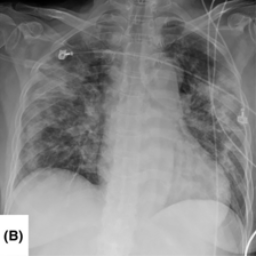

In [12]:
dataset[1]["image"]

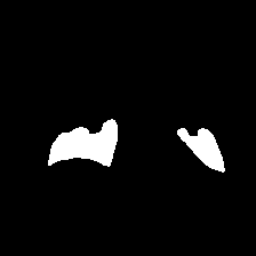

In [13]:
dataset[1]["label"]

In [14]:
from PIL import Image
from segment_anything import sam_model_registry 
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor
from torch.utils.data import Dataset, DataLoader
import glob
sam_checkpoint = '/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth'
model_type = "vit_b" #
device = "cuda" #cpu,cuda

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=16)
predictor = SamPredictor(sam)

In [15]:
def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m**0.5)))

Example of the Automatic Mask Generator not working on this dataset

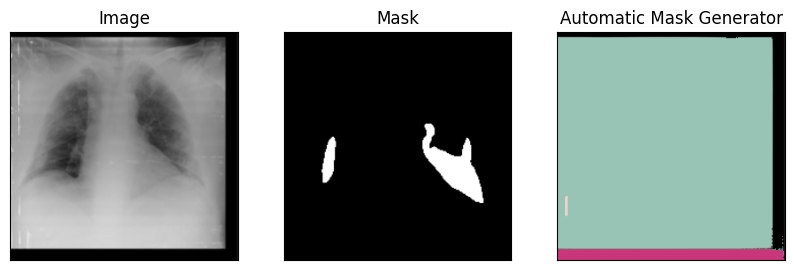

In [16]:
img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]
predictor.set_image(np.array(example_image))
input_box = np.array(get_bounding_box(np.array(example_mask)[:,:,0]))
#input_point = np.array(get_input_point(np.array(example_mask)[:,:,0]))
input_point = np.array([[180,160]])
input_label = np.array([0])

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    #box=input_box,
    multimask_output=False,
)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the predicted mask
masks = mask_generator.generate(np.array(example_image))
axes[2].imshow(example_image, cmap='gray')  # Assuming the second image is grayscale
show_anns(masks)
axes[2].set_title("Automatic Mask Generator")


# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Exaple of the pre-trained SAM not working well on the dataset

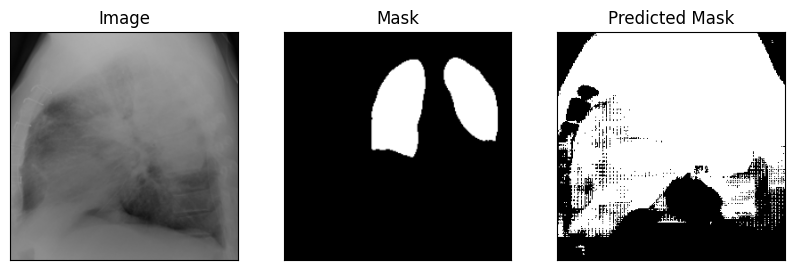

In [67]:
img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]
predictor.set_image(np.array(example_image))
input_box = np.array(get_bounding_box(np.array(example_mask)[:,:,0]))
input_point = np.array(get_input_point(np.array(example_mask)[:,:,0]))
#input_point = np.array([[80,150]])
input_label = np.array([0])

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    #box=input_box,
    multimask_output=False,
)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the predicted mask
axes[2].imshow(masks[0,:,:],cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Predicted Mask")


# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [68]:
input_point = np.array(get_input_point(np.array(example_mask)[:,:,0]))

In [69]:
input_point

array([[187,  32]])

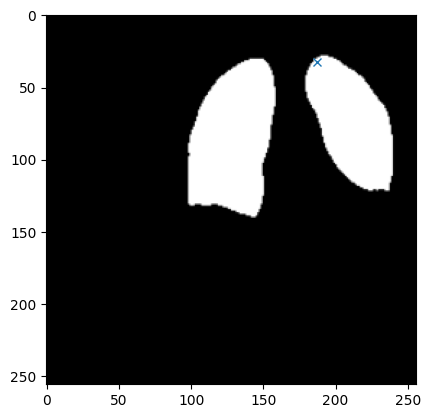

In [71]:
plt.imshow(example_mask)
plt.plot(187,32,marker='x')

Setup the Training Loop

In [72]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt_box = get_bounding_box(ground_truth_mask[:,:,0])
    prompt = get_input_point(ground_truth_mask[:,:,0])

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt_box]],input_points=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [73]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [74]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [75]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
input_points torch.Size([1, 1, 2])
ground_truth_mask (256, 256, 3)


In [76]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [77]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
input_points torch.Size([2, 1, 1, 2])
ground_truth_mask torch.Size([2, 256, 256, 3])


In [78]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256, 3])

In [79]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [80]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.FocalLoss(reduction='mean')

In [81]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      input_points=batch["input_points"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      
      loss = seg_loss(predicted_masks[:,0,:,:], ground_truth_masks[:,:,:,0])

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())
      
      #fig, axes = plt.subplots(1, 1, figsize=(5, 5))

      #axes.imshow(predicted_masks[0,0,:,:].detach().cpu(), cmap='gray')  # Assuming the first image is grayscale
      #axes.set_title("Image")

      # Display the images side by side
      #plt.show()

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    print(outputs.iou_scores)

100%|██████████| 3573/3573 [1:03:28<00:00,  1.07s/it]


EPOCH: 0
Mean loss: 0.1733299336813728
tensor([[[0.5993]]], device='cuda:0', grad_fn=<SliceBackward0>)


100%|██████████| 3573/3573 [1:03:22<00:00,  1.06s/it]

EPOCH: 1
Mean loss: 0.05958579619427616
tensor([[[0.4142]]], device='cuda:0', grad_fn=<SliceBackward0>)


Save the model

In [82]:
import pickle

# Save the Modle to file in the current working directory

Pkl_Filename = "Test_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

**Inference**

In [83]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [84]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
Pkl_Filename = "Test_Model.pkl"  
# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    my_mito_model = pickle.load(file)

#my_mito_model.load_state_dict(torch.load("/kaggle/input/qatacov19-dataset/QaTa-COV19")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [85]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [86]:
test_img_directory = "/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/"
test_ground_truth_directory = "/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/"

all_test_img_patches = []
i = 0
for item in os.listdir(test_img_directory):
    img_filename = os.fsdecode(item)
    #print(img_filename)
    image_information = cv2.imread(str(test_img_directory)+str(img_filename))
    image = image_information[:,:]
    image = cv2.resize(image, (256,256))
    #print(image_information)
    all_test_img_patches.append(image)
    #i+=1
    #if i>=100:
        #break
test_images = np.array(all_test_img_patches)

all_test_img_patches = []
j = 0
for item in os.listdir(test_ground_truth_directory):
    img_filename = os.fsdecode(item)
    #print(img_filename)
    image_information = cv2.imread(str(test_ground_truth_directory)+str(img_filename))
    image = image_information[:,:]
    image = cv2.resize(image, (256,256))
    #print(image_information)
    all_test_img_patches.append(image)
    #j+=1
    #if j>=100:
        #break
test_masks = np.array(all_test_img_patches)

In [87]:
# Create a list to store the indices of non-empty masks
valid_test_indices = [i for i, mask in enumerate(test_masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_test_images = test_images[valid_test_indices]
filtered_test_masks = test_masks[valid_test_indices]
print("Image shape:", filtered_test_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_test_masks.shape)

Image shape: (2113, 256, 256, 3)
Mask shape: (2113, 256, 256, 3)


In [88]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
test_dataset_dict = {
    "image": [Image.fromarray(img) for img in test_images],
    "label": [Image.fromarray(mask) for mask in test_masks],
}

# Create the dataset using the datasets.Dataset class
test_dataset = Dataset.from_dict(test_dataset_dict)

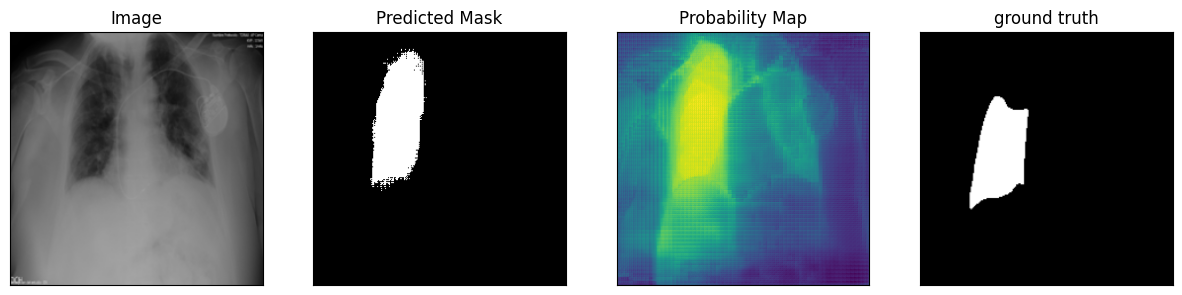

0.013343443822762154


In [106]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
# let's take a random training example
idx = random.randint(0, filtered_test_images.shape[0]-1)

# load image
test_image = test_dataset[idx]["image"]
#print(test_image.size)
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(test_dataset[idx]["label"])
prompt_box = get_bounding_box(ground_truth_mask[:,:,0])
prompt = get_input_point(ground_truth_mask[:,:,0])
# prepare image + box prompt for the model
inputs = processor(test_image, input_points=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Predicted Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Plot the ground truth image 
axes[3].imshow(test_dataset[idx]["label"])  # Assuming the second image is grayscale
axes[3].set_title("ground truth")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

truth = np.array(test_dataset[idx]["label"])[:,:,0]
truth = np.resize(truth, (truth.shape[0]*truth.shape[1],))
medsam_seg = np.resize(medsam_seg, (medsam_seg.shape[0]*medsam_seg.shape[1],))
print(jaccard_score(truth,medsam_seg, average='macro'))

In [107]:
iou_list = []
for i in tqdm(range(len(test_images))):    
    # load image
    test_image = test_dataset[i]["image"]
    #print(test_image.size)
    # get box prompt based on ground truth segmentation map
    ground_truth_mask = np.array(test_dataset[i]["label"])
    prompt_box = get_bounding_box(ground_truth_mask[:,:,0])
    prompt = get_input_point(ground_truth_mask[:,:,0])
    # prepare image + box prompt for the model
    inputs = processor(test_image, input_points=[[prompt]], return_tensors="pt")

    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}

    my_mito_model.eval()

    # forward pass
    with torch.no_grad():
        outputs = my_mito_model(**inputs, multimask_output=False)

    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    #truth = np.array(test_dataset[idx]["label"])[:,:,0]
    #truth = np.resize(truth, (truth.shape[0]*truth.shape[1],))
    #medsam_seg = np.resize(medsam_seg, (medsam_seg.shape[0]*medsam_seg.shape[1],))
    #iou_list.append(jaccard_score(truth,medsam_seg, average='macro'))
    
    gt_mask = np.array(test_dataset[i]["label"])[:,:,0].astype(bool)
    predicted_mask = np.array(medsam_seg).astype(bool)
    # Calculate Intersection over Union (IoU)
    intersection = np.logical_and(gt_mask, predicted_mask)
    union = np.logical_or(gt_mask, predicted_mask)
    iou = np.sum(intersection) / np.sum(union)
    #print(iou)
    iou_list.append(iou)

100%|██████████| 2113/2113 [18:53<00:00,  1.86it/s]


### CLIPSeg

In [3]:
!pip install -q transformers

In [4]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import torch
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/603M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


CLIPSegForImageSegmentation(
  (clip): CLIPSegModel(
    (text_model): CLIPSegTextTransformer(
      (embeddings): CLIPSegTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPSegEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPSegEncoderLayer(
            (self_attn): CLIPSegAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPSegMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=20

In [5]:
from PIL import Image
import requests

#url = "https://unsplash.com/photos/8Nc_oQsc2qQ/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjcxMjAwNzI0&force=true&w=640"
#image = Image.open(requests.get(url, stream=True).raw)
image = cv2.imread('/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Images/covid_1024.png')
#image = image.resize((256,256))
#image

In [6]:
import torch
prompts = ["lungs"]
inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt").to(device)
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

Unused or unrecognized kwargs: padding.


Example from pre-trained CLIPSeg

123904
(224, 224)


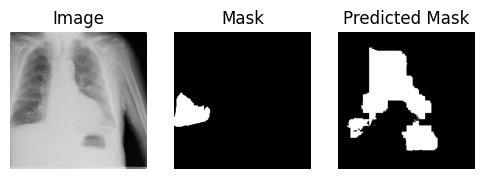

In [7]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 2, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
ax[0].set_title("Image")
#[ax[i+1].imshow(torch.sigmoid(preds[i][0]).cpu()) for i in range(len(prompts))];
#[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];
medsam_seg_prob = torch.sigmoid(preds.squeeze(1))

medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.08).astype(np.uint8)
ax[2].imshow(medsam_seg, cmap='gray')
ax[2].set_title("Predicted Mask")

mask = Image.open('/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Ground-truths/mask_covid_1024.png')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Mask")
print(medsam_seg.size)
print(mask.size)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [34]:
medsam_seg.shape

(352, 352)

In [35]:
#mask = Image.open('/kaggle/input/corsica-fires/test/masks/1815_5_5.png')
mask = mask.resize((352,352))
gt_mask = np.array(mask).astype(bool)
predicted_mask = np.array(medsam_seg).astype(bool)
# Calculate Intersection over Union (IoU)
intersection = np.logical_and(gt_mask, predicted_mask)
union = np.logical_or(gt_mask, predicted_mask)
iou = np.sum(intersection) / np.sum(union)
print(iou)

0.21977797730797485


In [56]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import monai
images = [img for img in glob.glob("/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Images/*.png")]
images.sort()
masks = [mask for mask in glob.glob("/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Train Set/Ground-truths/*.png")]
masks.sort()
#Training loop
num_epochs = 2
prob = 0.04
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
seg_loss = monai.losses.FocalLoss(reduction='mean')
model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for i in tqdm(range(len(images))):
      # forward pass
      prompts = ["X-ray lungs"]
      image = cv2.imread(images[i])
      inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt").to(device)
      # predict
      with torch.no_grad():
        outputs = model(**inputs)
      preds = outputs.logits.unsqueeze(1)
       # apply sigmoid
      #preds[0][0] = np.array(preds[0][0].cpu()).resize(256,256)
      medsam_seg_prob = torch.sigmoid(preds.squeeze(1))
      # convert soft mask to hard mask
      medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
      medsam_seg = torch.tensor((medsam_seg_prob > prob), dtype=torch.float) 
      # compute loss
      predicted_masks = medsam_seg
      #print((predicted_masks).shape)
      ground_truth_masks = Image.open(masks[i])
      ground_truth_masks = ground_truth_masks.resize((352,352))
      ground_truth_masks = torch.tensor(np.array(ground_truth_masks), dtype=torch.float) 
      #ground_truth_masks = ground_truth_masks.resize(2,352,352,3)
      #print(ground_truth_masks.shape)
      loss = seg_loss(predicted_masks, ground_truth_masks)

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.requires_grad = True
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')

100%|██████████| 7145/7145 [14:11<00:00,  8.39it/s]


EPOCH: 0
Mean loss: 0.3137612762590486


100%|██████████| 7145/7145 [06:39<00:00, 17.90it/s]

EPOCH: 1
Mean loss: 0.3137612762590486


In [57]:
# Save the model's state dictionary to a file
import pickle

Pkl_Filename = "Test_Model_fire.pkl"

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(model, file)

**Inference**

In [58]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import torch
# Load the model configuration

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create an instance of the model architecture with the loaded configuration
my_fire_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
#Update the model by loading the weights from saved file.
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:
    my_fire_model = pickle.load(file)

In [61]:
from tqdm import tqdm
import glob
images = [img for img in glob.glob("/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/*.png")]
images.sort()
masks = [mask for mask in glob.glob("/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/*.png")]
masks.sort()
probabilities=[0.01,0.02,0.03,0.04,0.05]
iou_list = []
for i in tqdm(range(len(images))):
  image = cv2.imread(images[i])
  inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt").to(device)
  with torch.no_grad():
    outputs = my_fire_model(**inputs)
  preds = outputs.logits.unsqueeze(1)
  iou = 0
  for prob in probabilities:
     # apply sigmoid
     medsam_seg_prob = torch.sigmoid(preds.squeeze(1))
     # convert soft mask to hard mask
     medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
     medsam_seg = (medsam_seg_prob > prob).astype(np.uint8) 
     mask = Image.open(masks[i])
     mask = mask.resize((352,352))
     gt_mask = np.array(mask).astype(bool)
     predicted_mask = np.array(medsam_seg).astype(bool)
     # Calculate Intersection over Union (IoU)
     intersection = np.logical_and(gt_mask, predicted_mask)
     union = np.logical_or(gt_mask, predicted_mask)
     iou_next = np.sum(intersection) / np.sum(union)
     if iou_next > iou:
        iou = iou_next
  #print(iou)
  iou_list.append(iou)

100%|██████████| 2113/2113 [04:07<00:00,  8.54it/s]


Example of the fine-tuned CLIPSeg on a random image of the test set

In [112]:
image = cv2.imread('/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S09308_ses-E20733_acq-2_run-1_bp-chest_vp-ap_dx.png')
prompts = ["lungs"]
inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt").to(device)
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

Unused or unrecognized kwargs: padding.


123904
(224, 224)


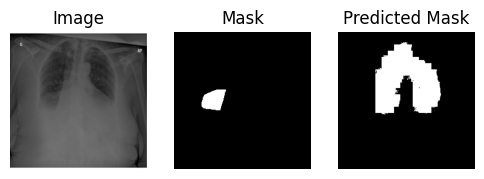

In [114]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 2, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
ax[0].set_title("Image")
#[ax[i+1].imshow(torch.sigmoid(preds[i][0]).cpu()) for i in range(len(prompts))];
#[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];
medsam_seg_prob = torch.sigmoid(preds.squeeze(1))

medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.1).astype(np.uint8)
ax[2].imshow(medsam_seg, cmap='gray')
ax[2].set_title("Predicted Mask")

mask = Image.open('/kaggle/input/qatacov19-dataset/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S09308_ses-E20733_acq-2_run-1_bp-chest_vp-ap_dx.png')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Mask")

print(medsam_seg.size)
print(mask.size)